# 🏃🏽‍♀️ Training a Rockpool network with Jax

In [1]:
# -- Some useful imports

# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

# - Rich printing
try:
    from rich import print
except:
    pass

# - Numpy
import numpy as np

# - Import and configure matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

## Jax considerations

## Loss functions

### Loss function components provided by Rockpool

In [2]:
# - Import the loss components for use
from rockpool.training import jax_loss as l

### Writing your own loss function

In [3]:
def loss_mse(parameters, net, inputs, target):
    # - Handle the network state — randomise or reset
    net = net.reset_state()
    
    # - Assign the provided parameters to the network
    net = net.set_attributes(parameters)
       
    # - Evolve the network to get the ouput
    output, _, _ = net(inputs)
    
    # - Compute a loss value w.r.t. the target output
    return l.mse(output, target)

## Defining a task dataset

In [4]:
# - Define a dataset class implementing the indexing interface
class MultiClassRandomSinMapping:
    def __init__(self,
                 num_classes: int = 2,
                 sample_length: int = 100,
                 input_channels: int = 50,
                 target_channels: int = 2):
        # - Record task parameters
        self._num_classes = num_classes
        self._sample_length = sample_length
        
        # - Draw random input signals
        self._inputs = np.random.randn(num_classes, sample_length, input_channels) + 1.
        
        # - Draw random sinusoidal target parameters
        self._target_phase = np.random.rand(num_classes, 1, target_channels) * 2 * np.pi
        self._target_omega = np.random.rand(num_classes, 1, target_channels) * sample_length / 50
        
        # - Generate target output signals
        time_base = np.atleast_2d(np.arange(sample_length) / sample_length).T
        self._targets = np.sin(2 * np.pi * self._target_omega * time_base + self._target_phase)
    
    def __len__(self):
        # - Return the total size of this dataset
        return self._num_classes
    
    def __getitem__(self, i):
        # - Return the indexed dataset sample
        return self._inputs[i], self._targets[i]

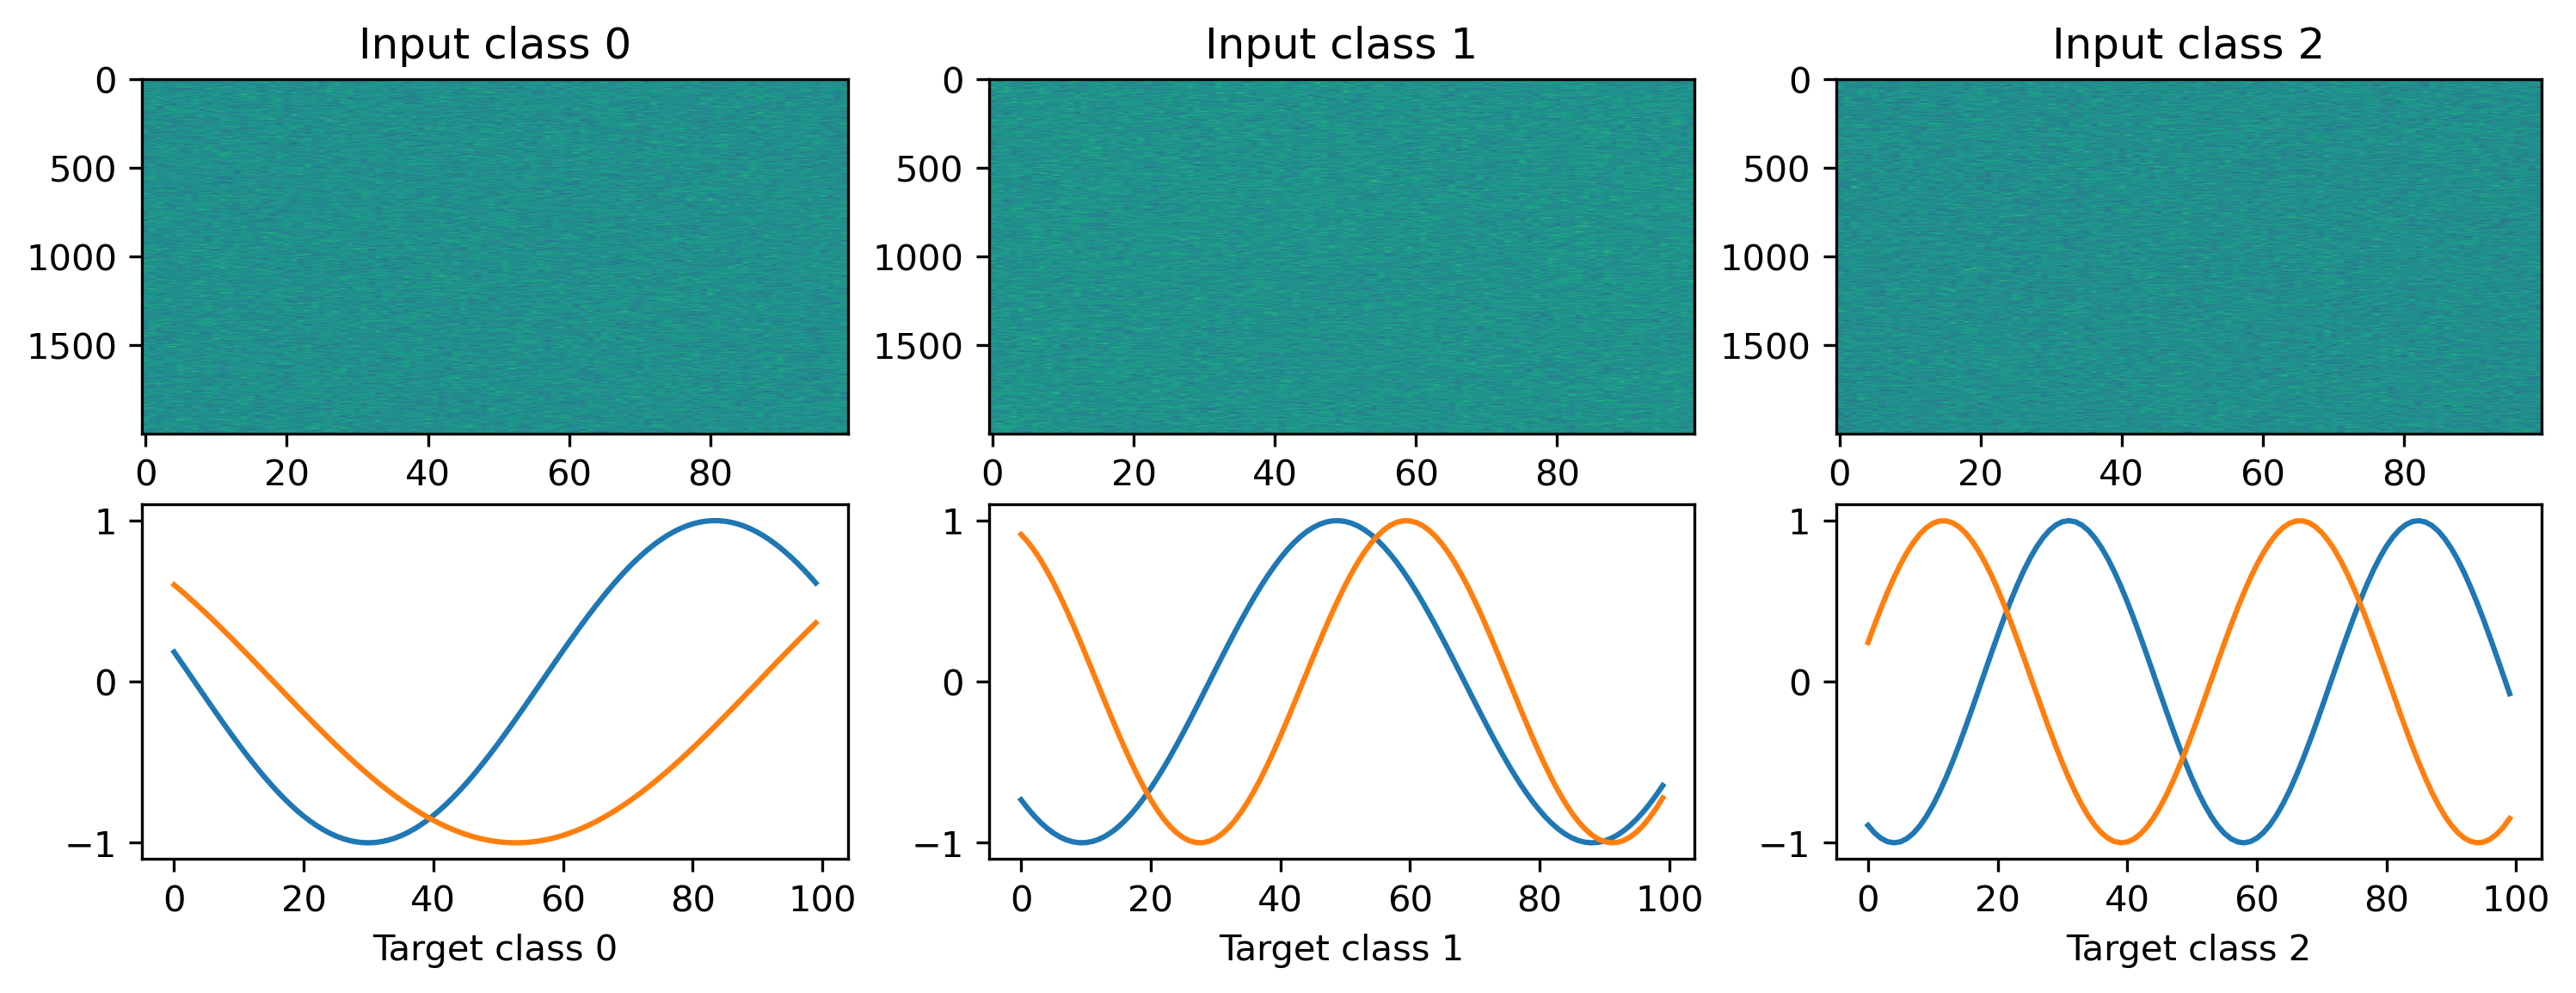

In [5]:
# - Instantiate a dataset
Nin = 2000
Nout = 2
num_classes = 3
T = 100
ds = MultiClassRandomSinMapping(num_classes = num_classes,
                                input_channels = Nin,
                                target_channels = Nout,
                                sample_length = T,
                               )

# Display the dataset classes
plt.figure()
for i, sample in enumerate(ds):
    plt.subplot(2, len(ds), i + 1)
    plt.imshow(sample[0].T, aspect='auto')
    plt.title(f'Input class {i}')
    
    plt.subplot(2, len(ds), i + len(ds) + 1)
    plt.plot(sample[1])
    plt.xlabel(f'Target class {i}')

## Building a Jax network

In [6]:
# - Import the Rockpool modules and Sequential combinator
from rockpool.nn.modules import LinearJax, InstantJax
from rockpool.nn.combinators import Sequential

import jax
import jax.numpy as jnp

Nhidden = 8

net = Sequential(
    LinearJax((Nin, Nhidden)),
    InstantJax(Nhidden, jnp.tanh),
    LinearJax((Nhidden, Nout)),
)
print(net)

Could not import package: No module named 'iaf_nest'


JaxSequential  with shape (2000, 2) {
    LinearJax '0_LinearJax' with shape (2000, 8)
    InstantJax '1_InstantJax' with shape (8,)
    LinearJax '2_LinearJax' with shape (8, 2)
}

## Writing a training loop

In [7]:
# - Useful imports
from tqdm.autonotebook import tqdm
from copy import deepcopy
from itertools import count

# -- Import an optimiser to use and initalise it
import jax
from jax.experimental.optimizers import adam, sgd

# - Get the optimiser functions
init_fun, update_fun, get_params = adam(1e-4)

# - Initialise the optimiser with the initial parameters
params0 = deepcopy(net.parameters())
opt_state = init_fun(params0)

# - Get a compiled value-and-gradient function
loss_vgf = jax.jit(jax.value_and_grad(loss_mse))

# - Compile the optimiser update function
update_fun = jax.jit(update_fun)

# - Record the loss values over training iterations
loss_t = []
grad_t = []

num_epochs = 1000

# - Loop over iterations
i_trial = count()
for _ in tqdm(range(num_epochs)):
    for sample in ds:
        # - Get an input / target sample
        input, target = sample[0], sample[1]
        
        # - Get parameters for this iteration
        params = get_params(opt_state)

        # - Get the loss value and gradients for this iteration
        loss_val, grads = loss_vgf(params, net, input, target)

        # - Update the optimiser
        opt_state = update_fun(next(i_trial), grads, opt_state)
        
        # - Keep track of the loss
        loss_t.append(loss_val)

  0%|          | 0/1000 [00:00<?, ?it/s]

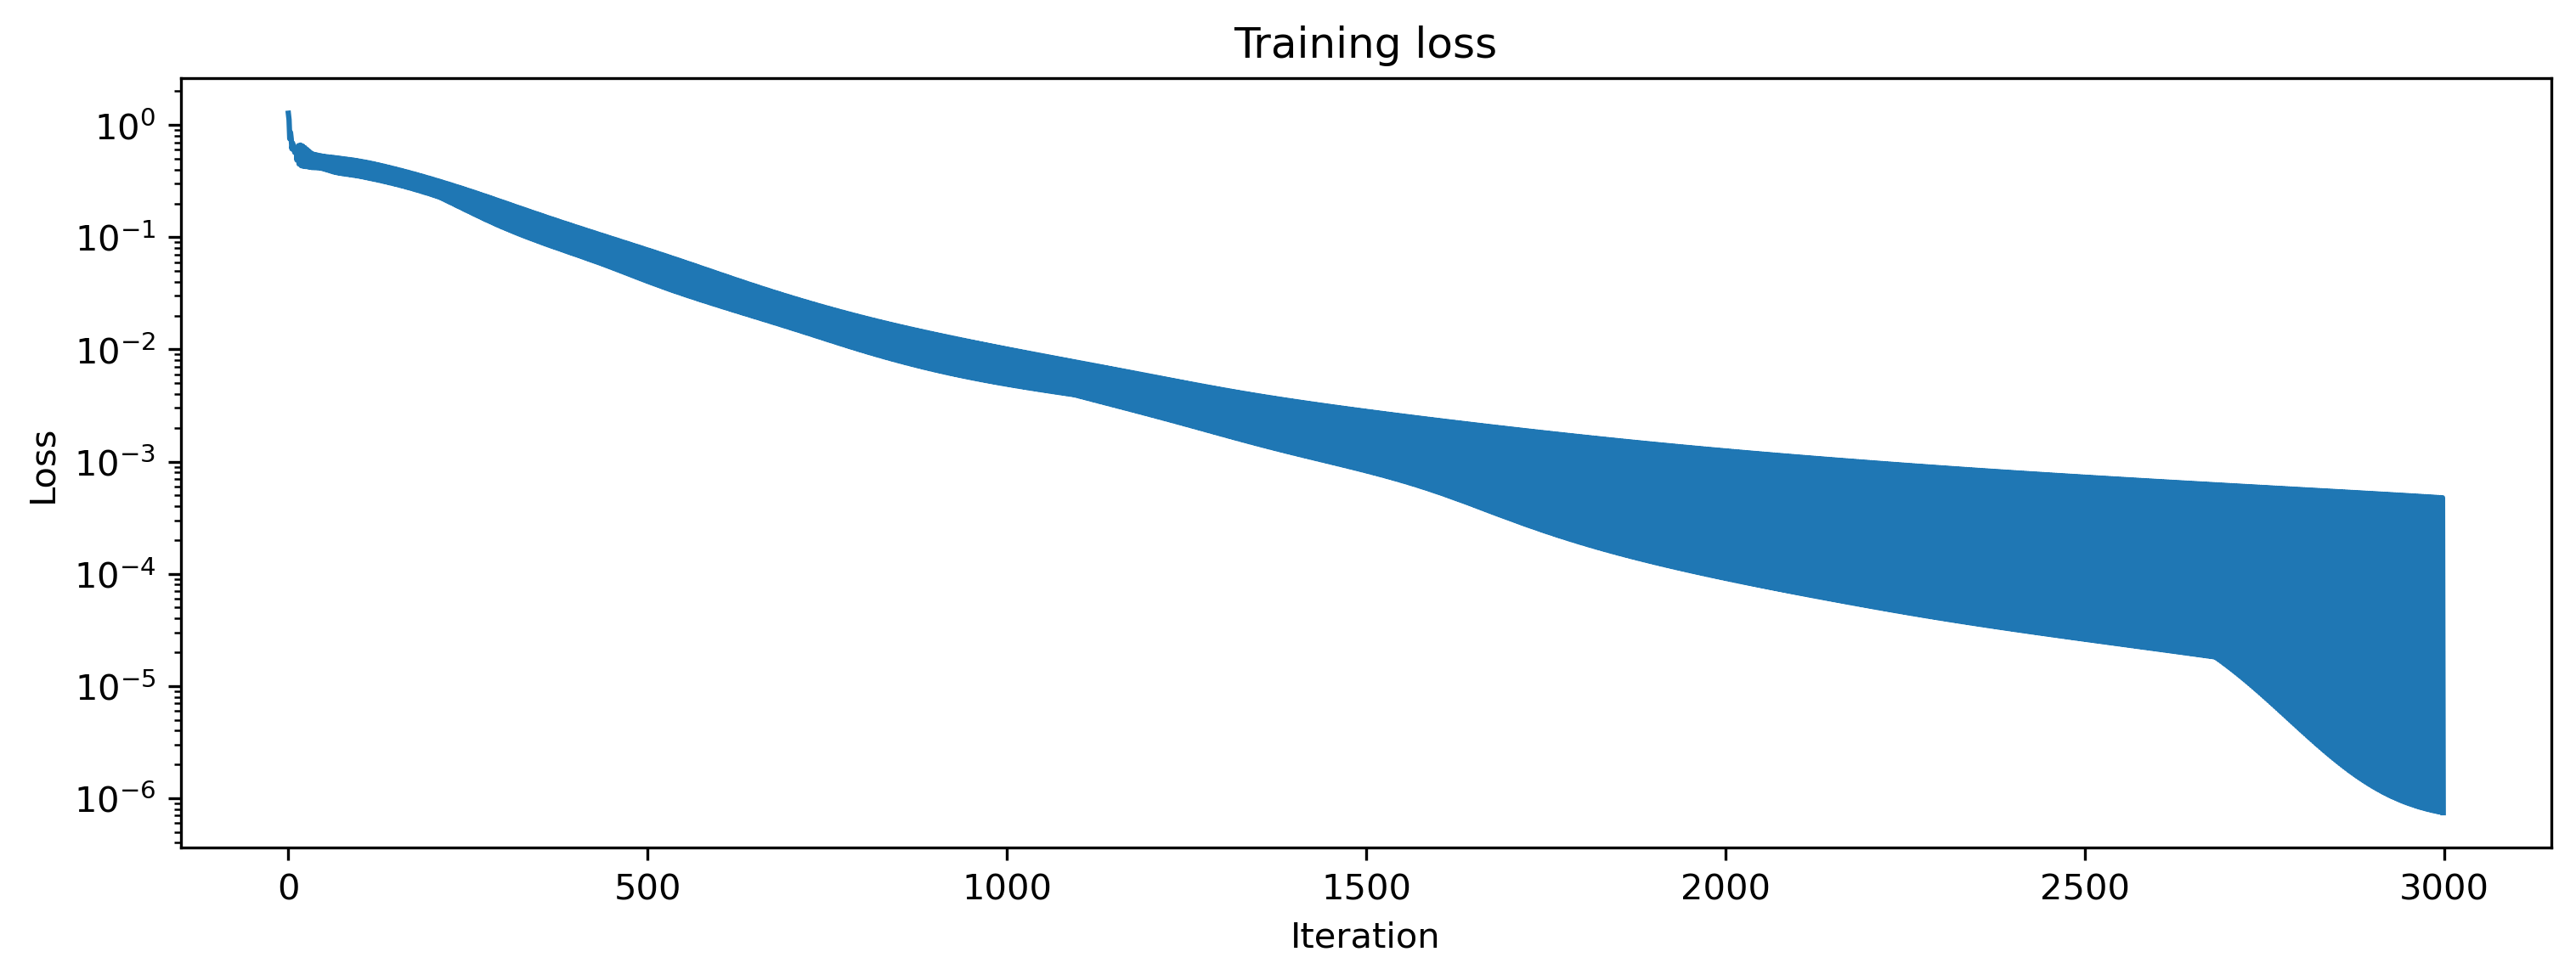

In [8]:
# - Plot the loss over iterations
plt.plot(np.array(loss_t))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss');

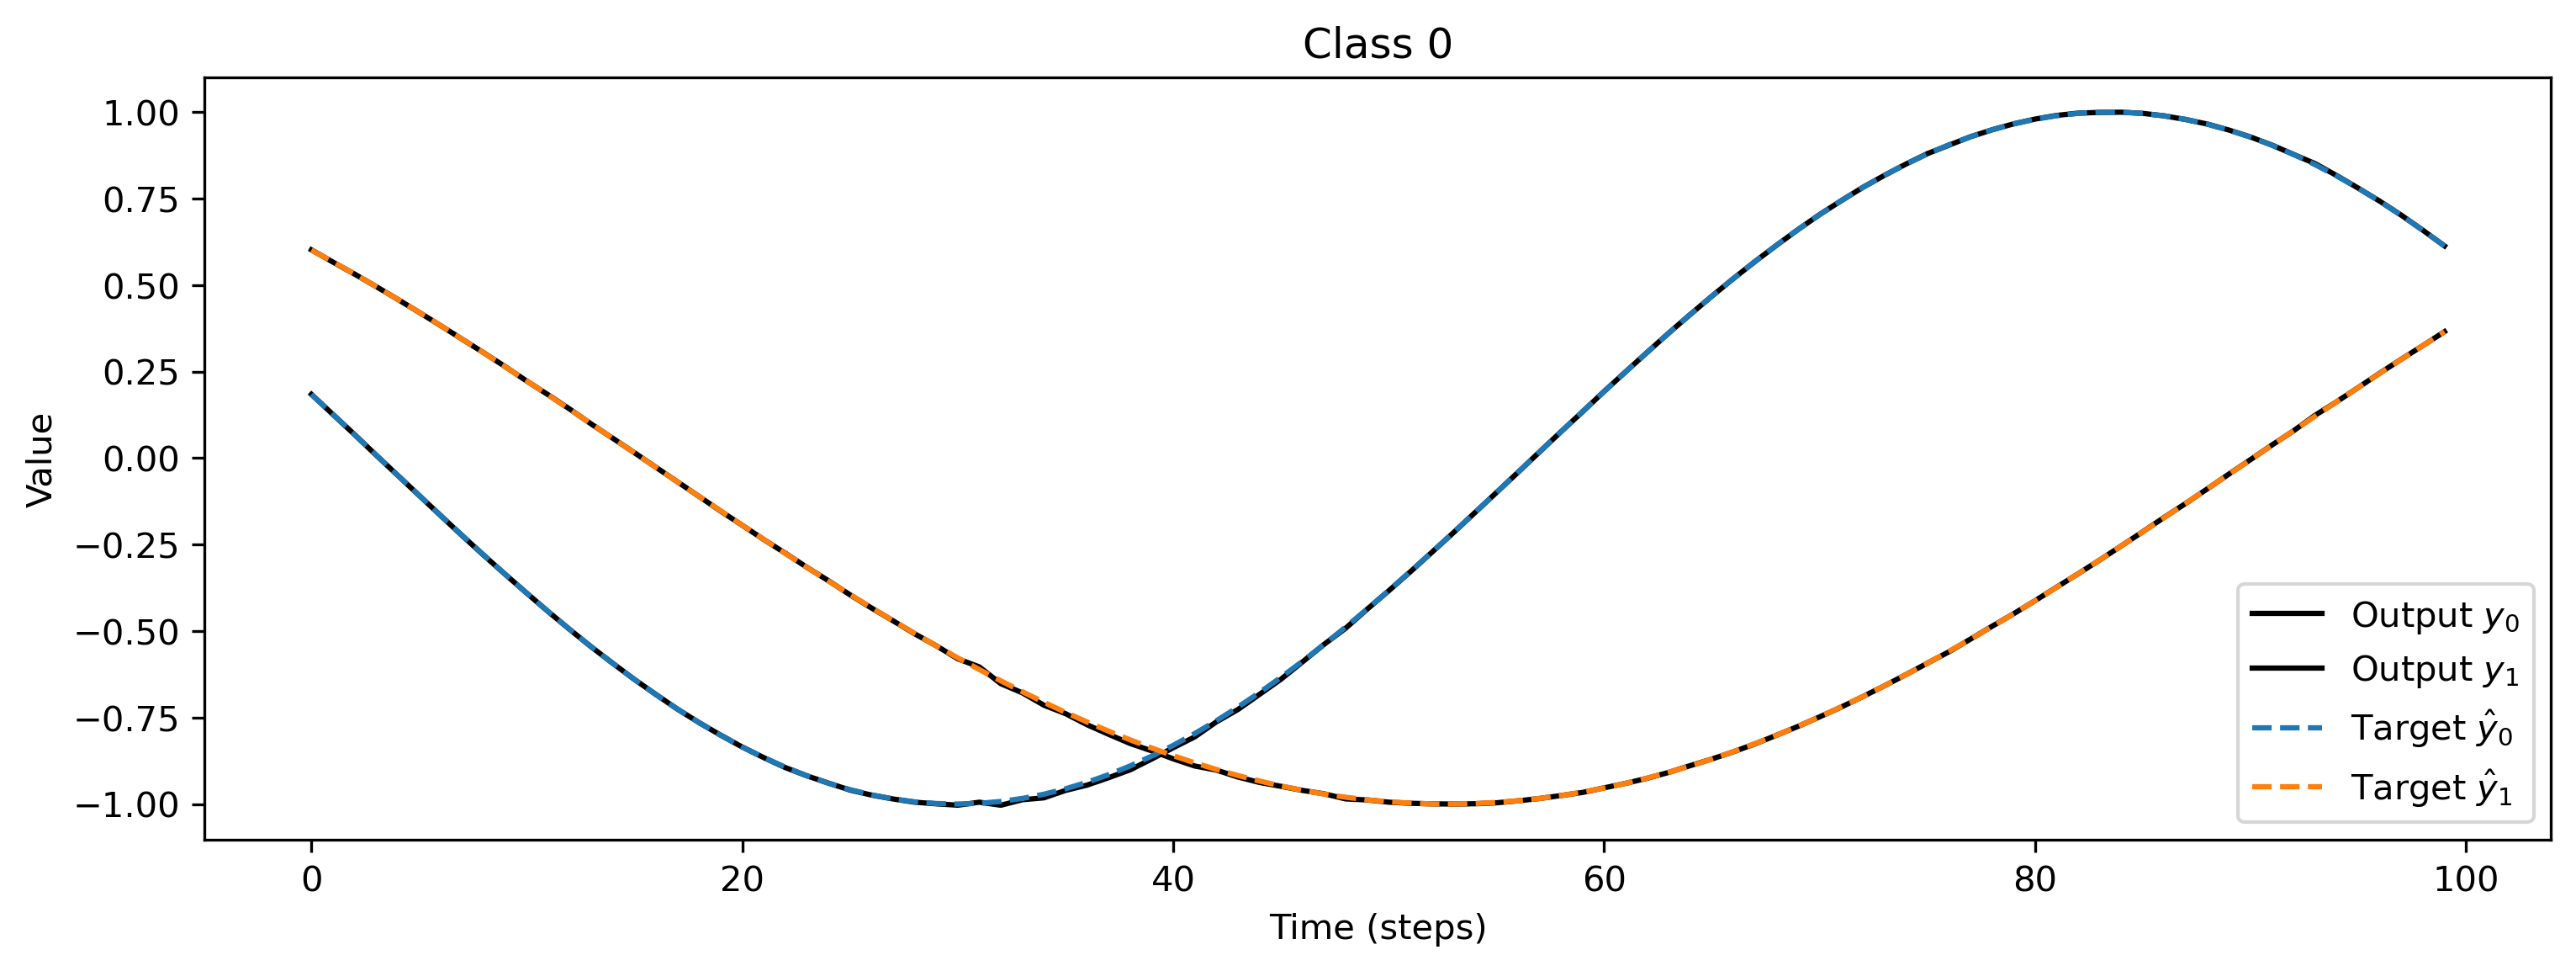

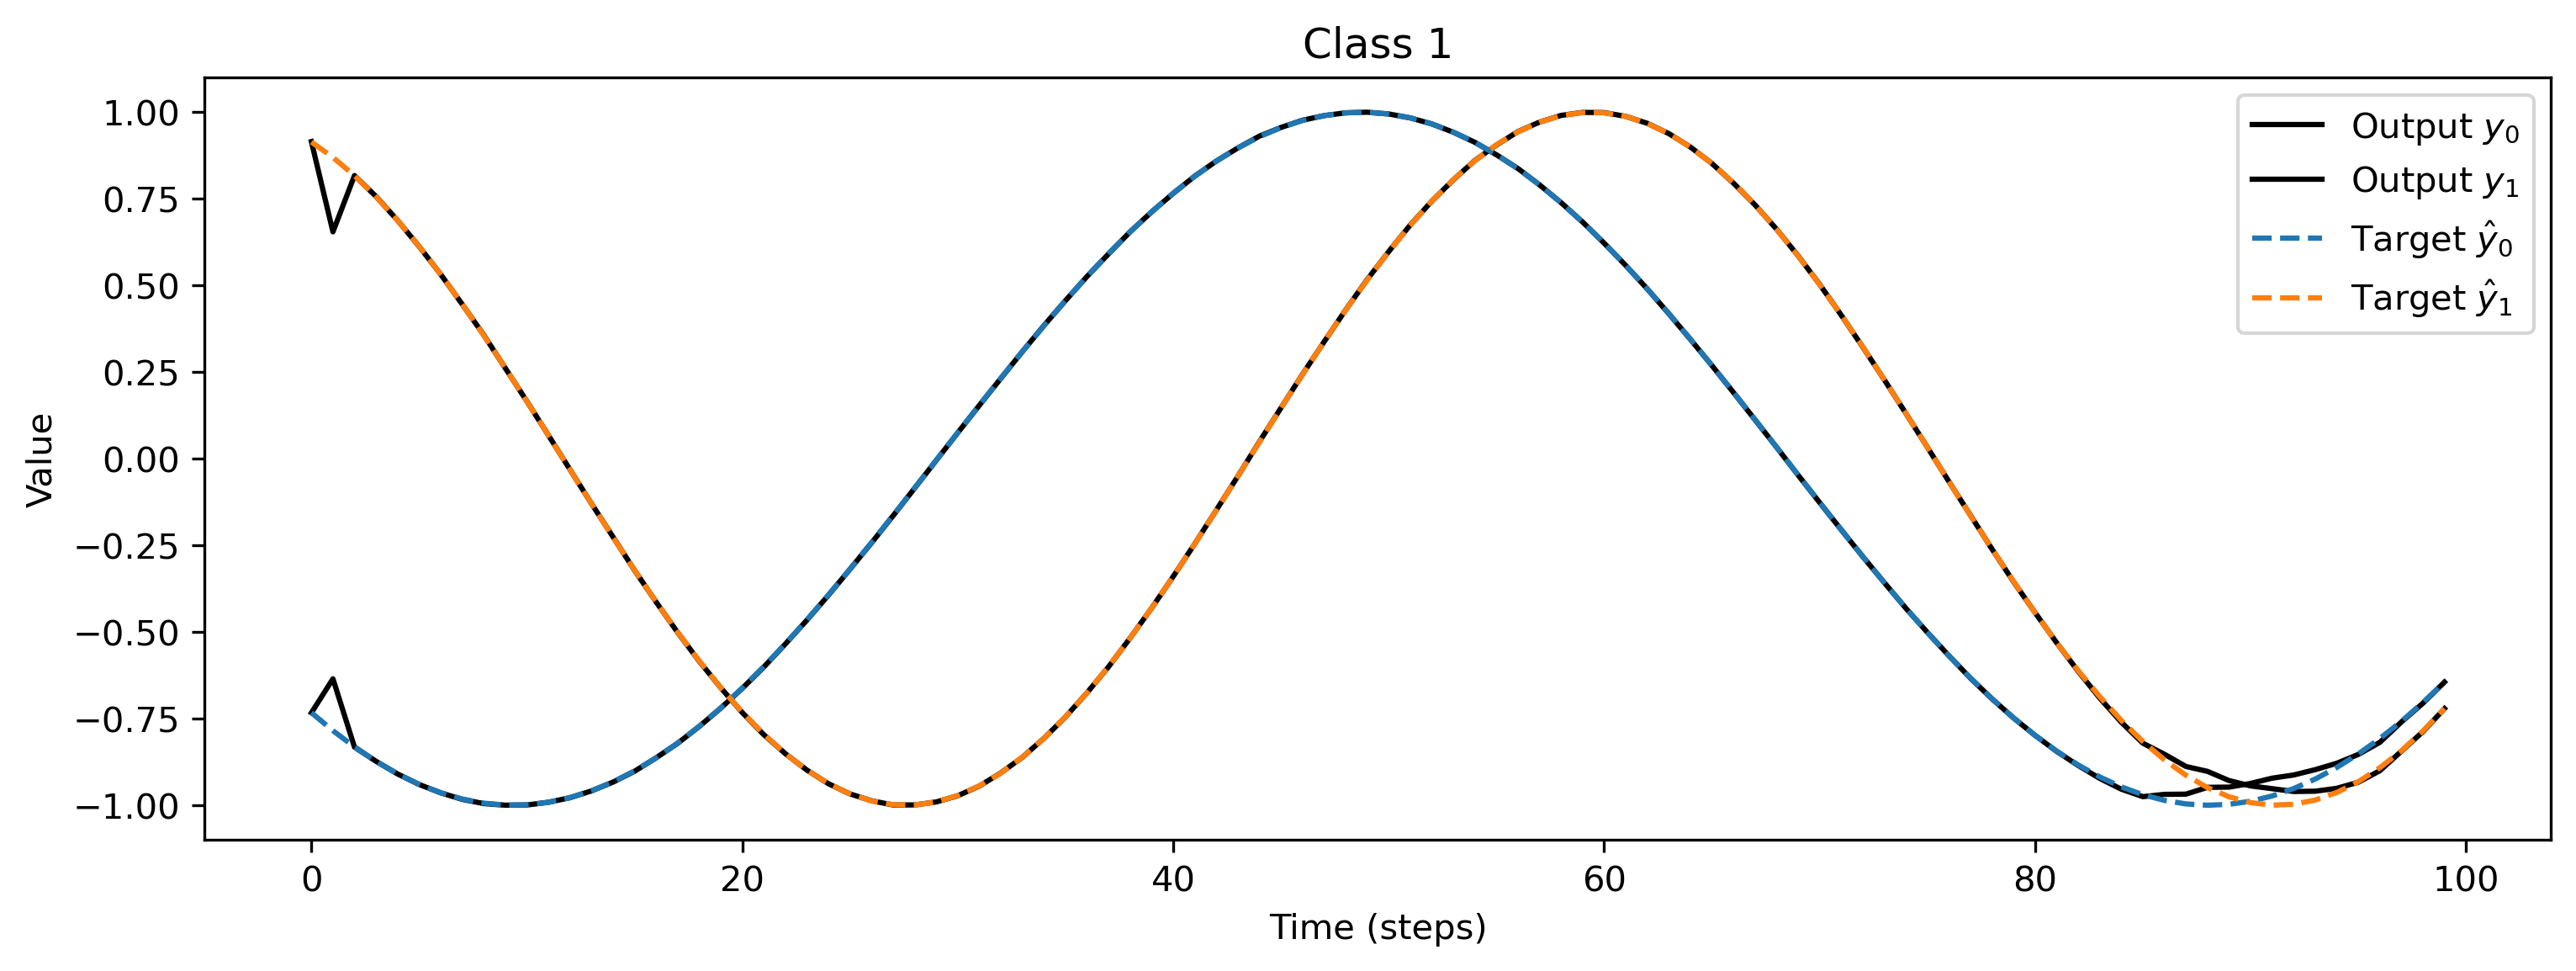

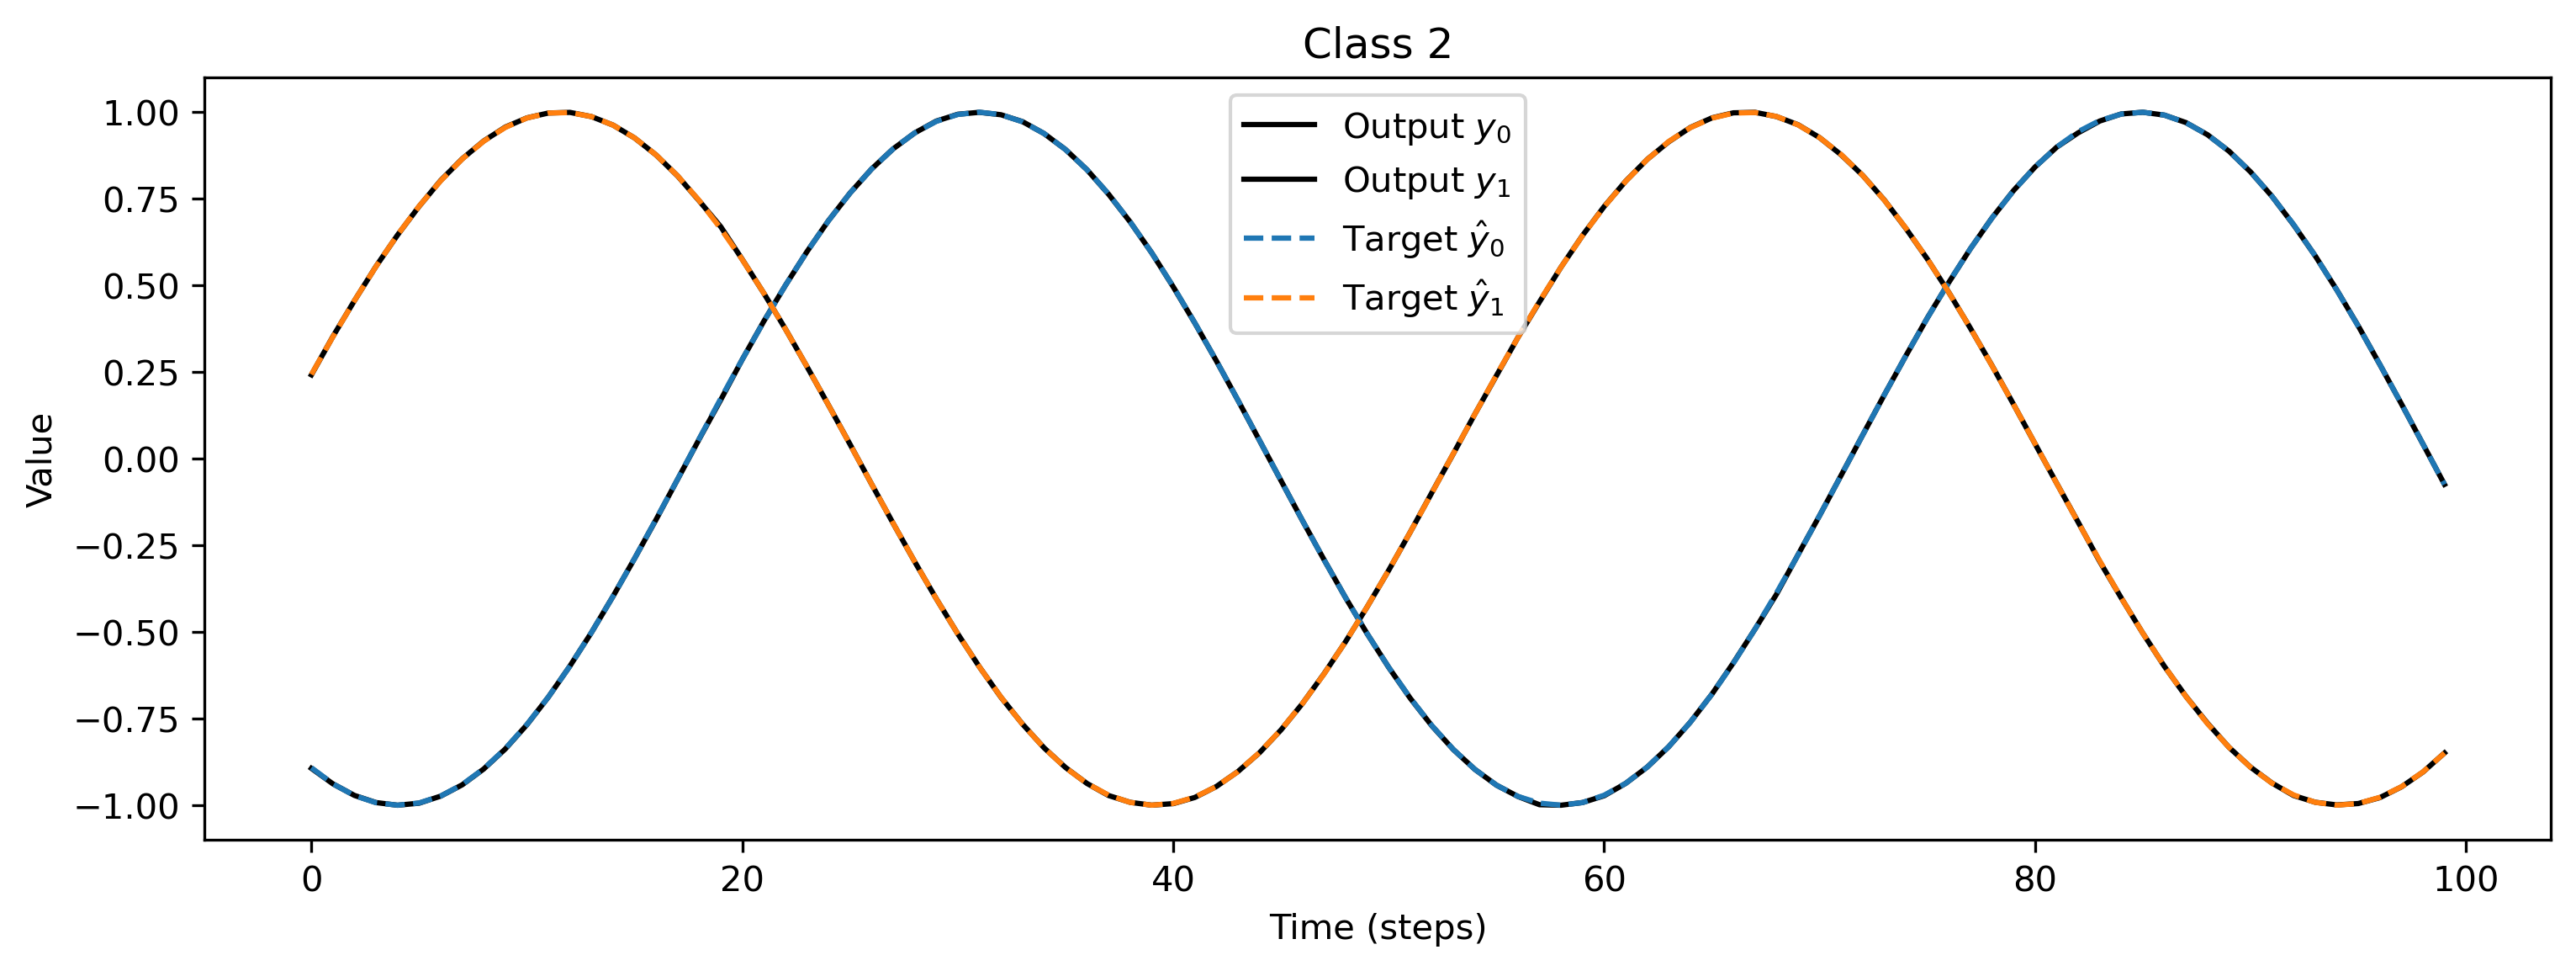

In [9]:
# - Apply the trained parameters to the network
params_hat = get_params(opt_state)
net = net.set_attributes(params_hat)

# - Evaluate classes
for i_class, sample in enumerate(ds):
    input, target = sample

    # - Evaluate network
    net = net.reset_state()
    output, _, _ = net(input, record = True)
    
    # - Plot output and target
    plt.figure()
    plt.plot(output, 'k-')
    plt.plot(sample[1], '--')
    plt.xlabel('Time (steps)')
    plt.ylabel('Value')
    plt.legend(['Output $y_0$',
                'Output $y_1$',
                'Target $\hat{y}_0$',
                'Target $\hat{y}_1$',
               ])
    plt.title(f'Class {i_class}')

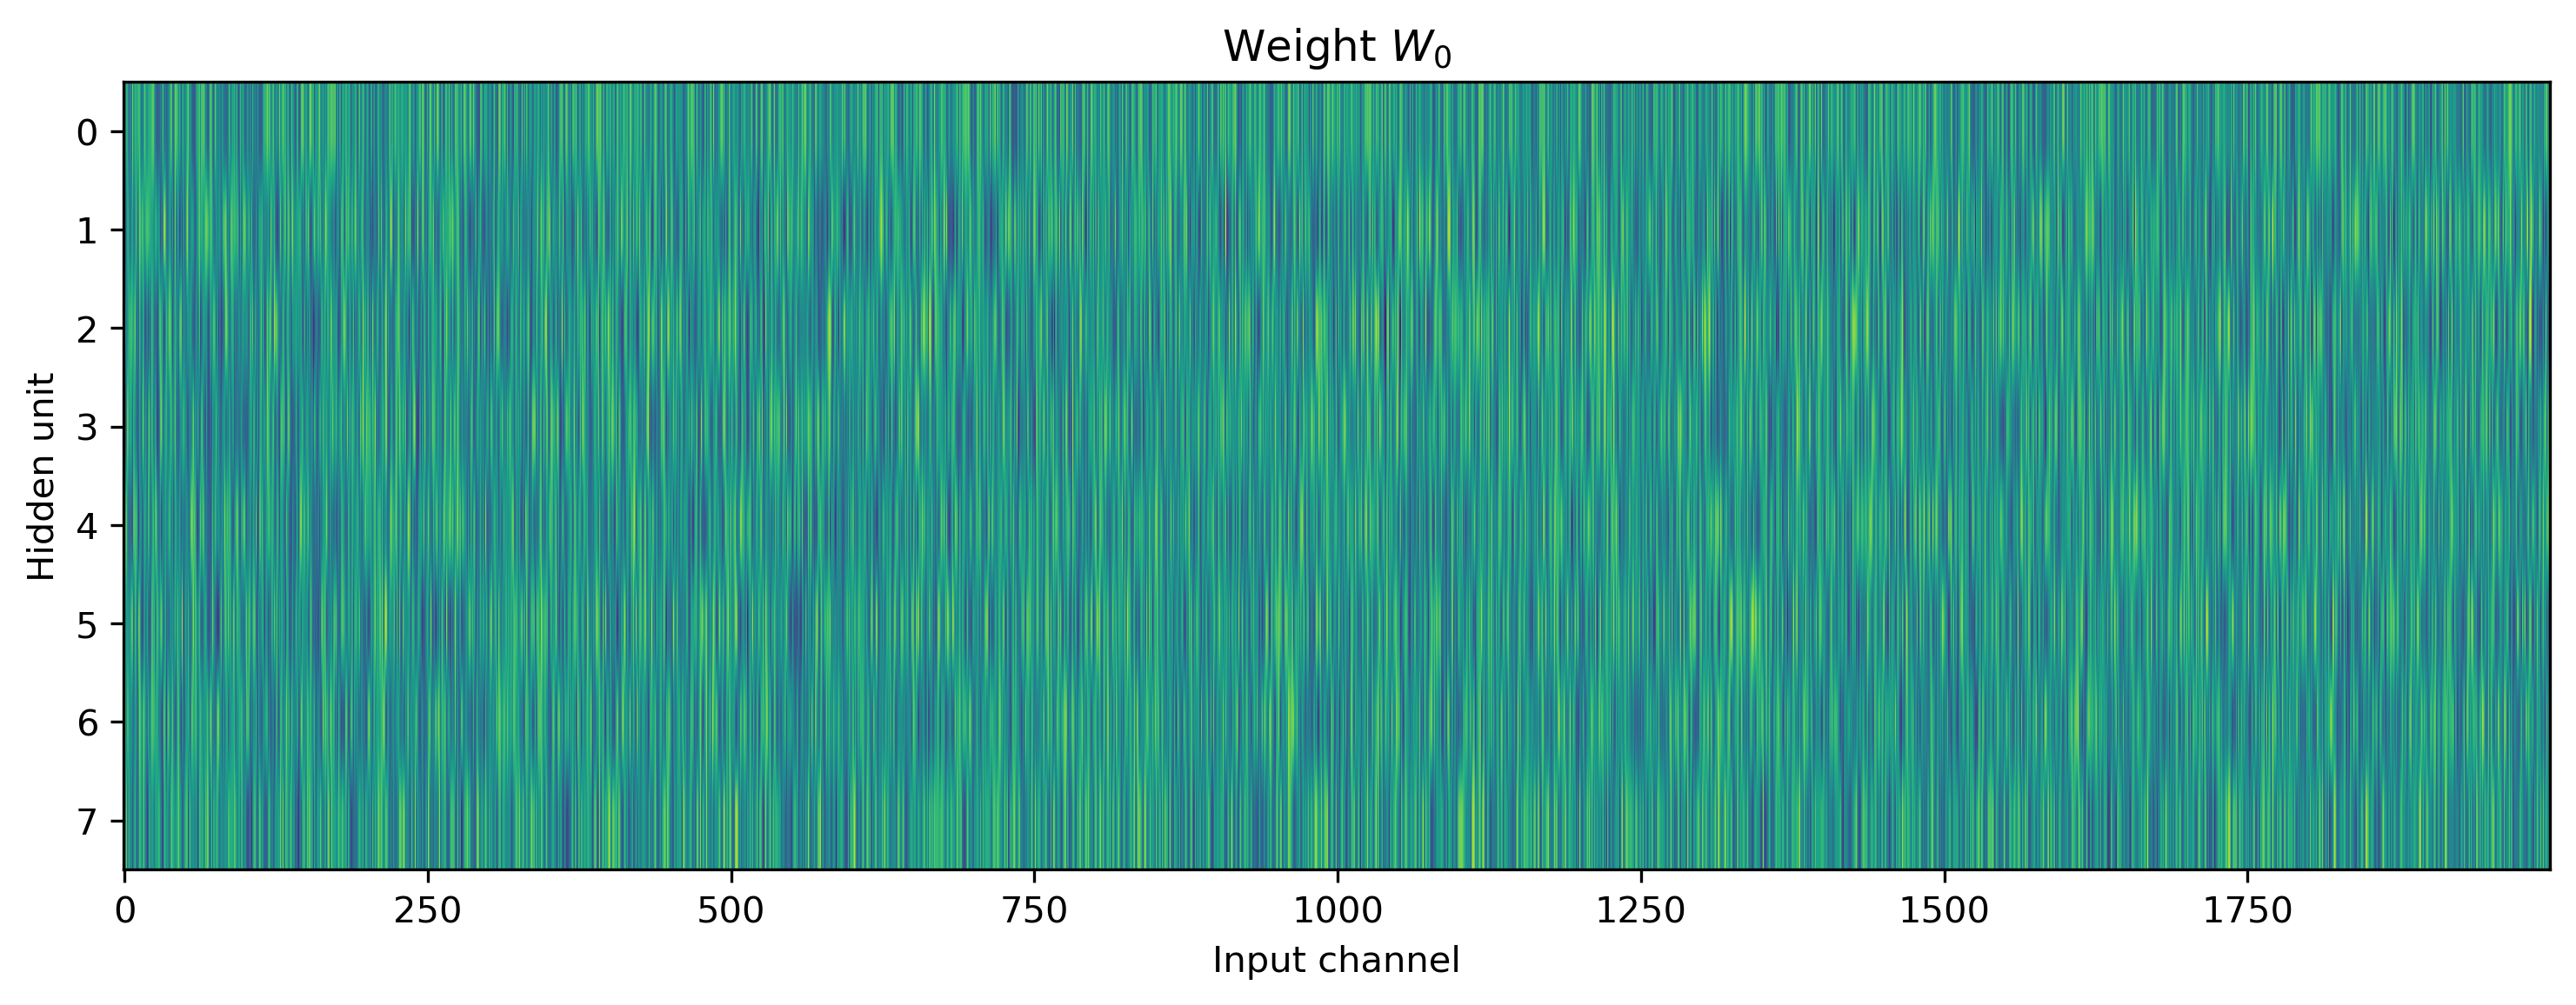

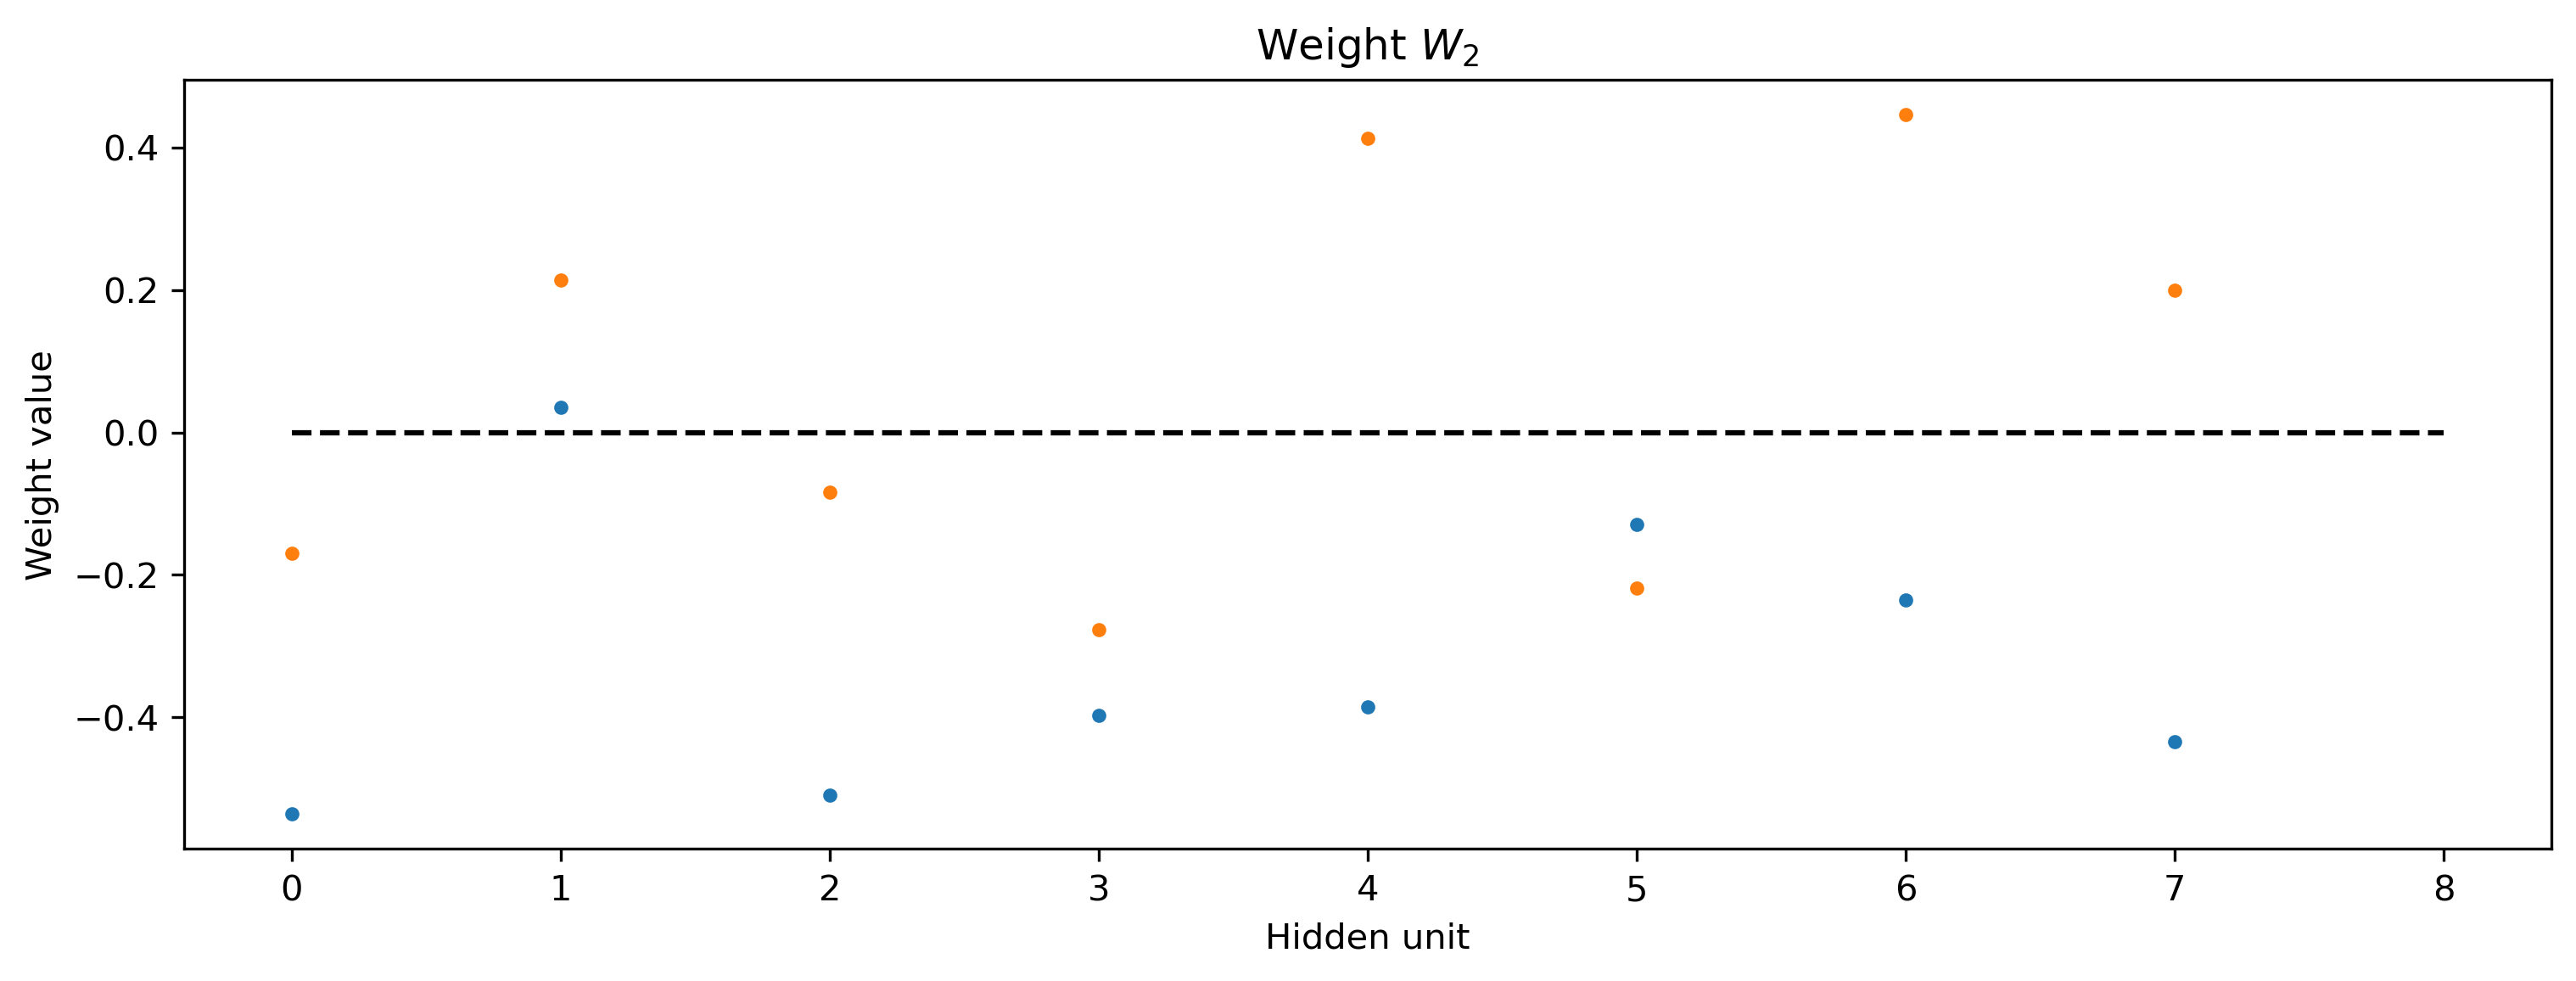

In [10]:
# - Display network parameters
plt.figure()
plt.imshow(net[0].weight.T, aspect = 'auto')
plt.xlabel('Input channel')
plt.ylabel('Hidden unit')
plt.title('Weight $W_0$')

plt.figure()
plt.plot(net[2].weight, '.')
plt.plot([0, Nhidden], [0, 0], 'k--')
plt.xlabel('Hidden unit')
plt.ylabel('Weight value');
plt.title('Weight $W_2$');

# 👩🏽‍🔬 Advanced Jax training topics

## Providing bounds on parameters during optimisation

In [11]:
# - Import the rate-based stateful module `RateEulerJax`
from rockpool.nn.modules import RateJax

# - Build a Jax network including a stateful module
Nhidden = 200
net_stateful = Sequential(
    LinearJax((Nin, Nhidden)),
    RateJax(Nhidden, activation_func = 'tanh'),
    LinearJax((Nhidden, Nout)),
)
print(net_stateful)

JaxSequential  with shape (2000, 2) {
    LinearJax '0_LinearJax' with shape (2000, 200)
    RateJax '1_RateJax' with shape (200,)
    LinearJax '2_LinearJax' with shape (200, 2)
}

In [12]:
# - Import the convenience functions
from rockpool.training.jax_loss import bounds_cost, make_bounds

# - Generate a set of pre-configured bounds
lower_bounds, upper_bounds = make_bounds(net_stateful.parameters())
print('lower_bounds: ', lower_bounds,
      'upper_bounds: ', upper_bounds)

lower_bounds: 
{
    '0_LinearJax': {'bias': -inf, 'weight': -inf},
    '1_RateJax': {'bias': -inf, 'tau': -inf, 'threshold': -inf},
    '2_LinearJax': {'bias': -inf, 'weight': -inf}
}
upper_bounds: 
{
    '0_LinearJax': {'bias': inf, 'weight': inf},
    '1_RateJax': {'bias': inf, 'tau': inf, 'threshold': inf},
    '2_LinearJax': {'bias': inf, 'weight': inf}
}

In [13]:
# - Configure the bounds for this network
lower_bounds['1_RateJax']['tau'] = 10e-3
print('lower_bounds: ', lower_bounds)

lower_bounds: 
{
    '0_LinearJax': {'bias': -inf, 'weight': -inf},
    '1_RateJax': {'bias': -inf, 'tau': 0.01, 'threshold': -inf},
    '2_LinearJax': {'bias': -inf, 'weight': -inf}
}

In [14]:
def loss_mse_reg_bounds(parameters, net, inputs, target):
    # - Handle the network state — randomise or reset
    net = net.reset_state()
    
    # - Assign the provided parameters to the network
    net = net.set_attributes(parameters)
       
    # - Evolve the network to get the ouput
    output, _, _ = net(inputs)
    
    # - Compute a loss value w.r.t. the target output
    mse = l.mse(output, target)
    
    # - Add some parameter regularisation
    reg = l.l2sqr_norm(parameters) * 1e3
    
    # - Impose the bounds
    bounds = bounds_cost(parameters, lower_bounds, upper_bounds) * 1e3
    
    return mse + reg + bounds

In [15]:
# - Initialise the optimiser with the initial parameters
params0 = deepcopy(net_stateful.parameters())
opt_state = init_fun(params0)

# - Get a compiled value-and-gradient function for the new loss
loss_vgf = jax.jit(jax.value_and_grad(loss_mse_reg_bounds))

# - Compile the optimiser update function
update_fun = jax.jit(update_fun)

# - Record the loss values over training iterations
loss_t = []
grad_t = []

num_epochs = 1000

# - Loop over iterations
i_trial = count()
for _ in tqdm(range(num_epochs)):
    for sample in ds:
        # - Get an input / target sample
        input, target = sample[0], sample[1]
        
        # - Get parameters for this iteration
        params = get_params(opt_state)

        # - Get the loss value and gradients for this iteration
        loss_val, grads = loss_vgf(params, net_stateful, input, target)

        # - Update the optimiser
        opt_state = update_fun(next(i_trial), grads, opt_state)
        
        # - Keep track of the loss
        loss_t.append(loss_val)

  0%|          | 0/1000 [00:00<?, ?it/s]

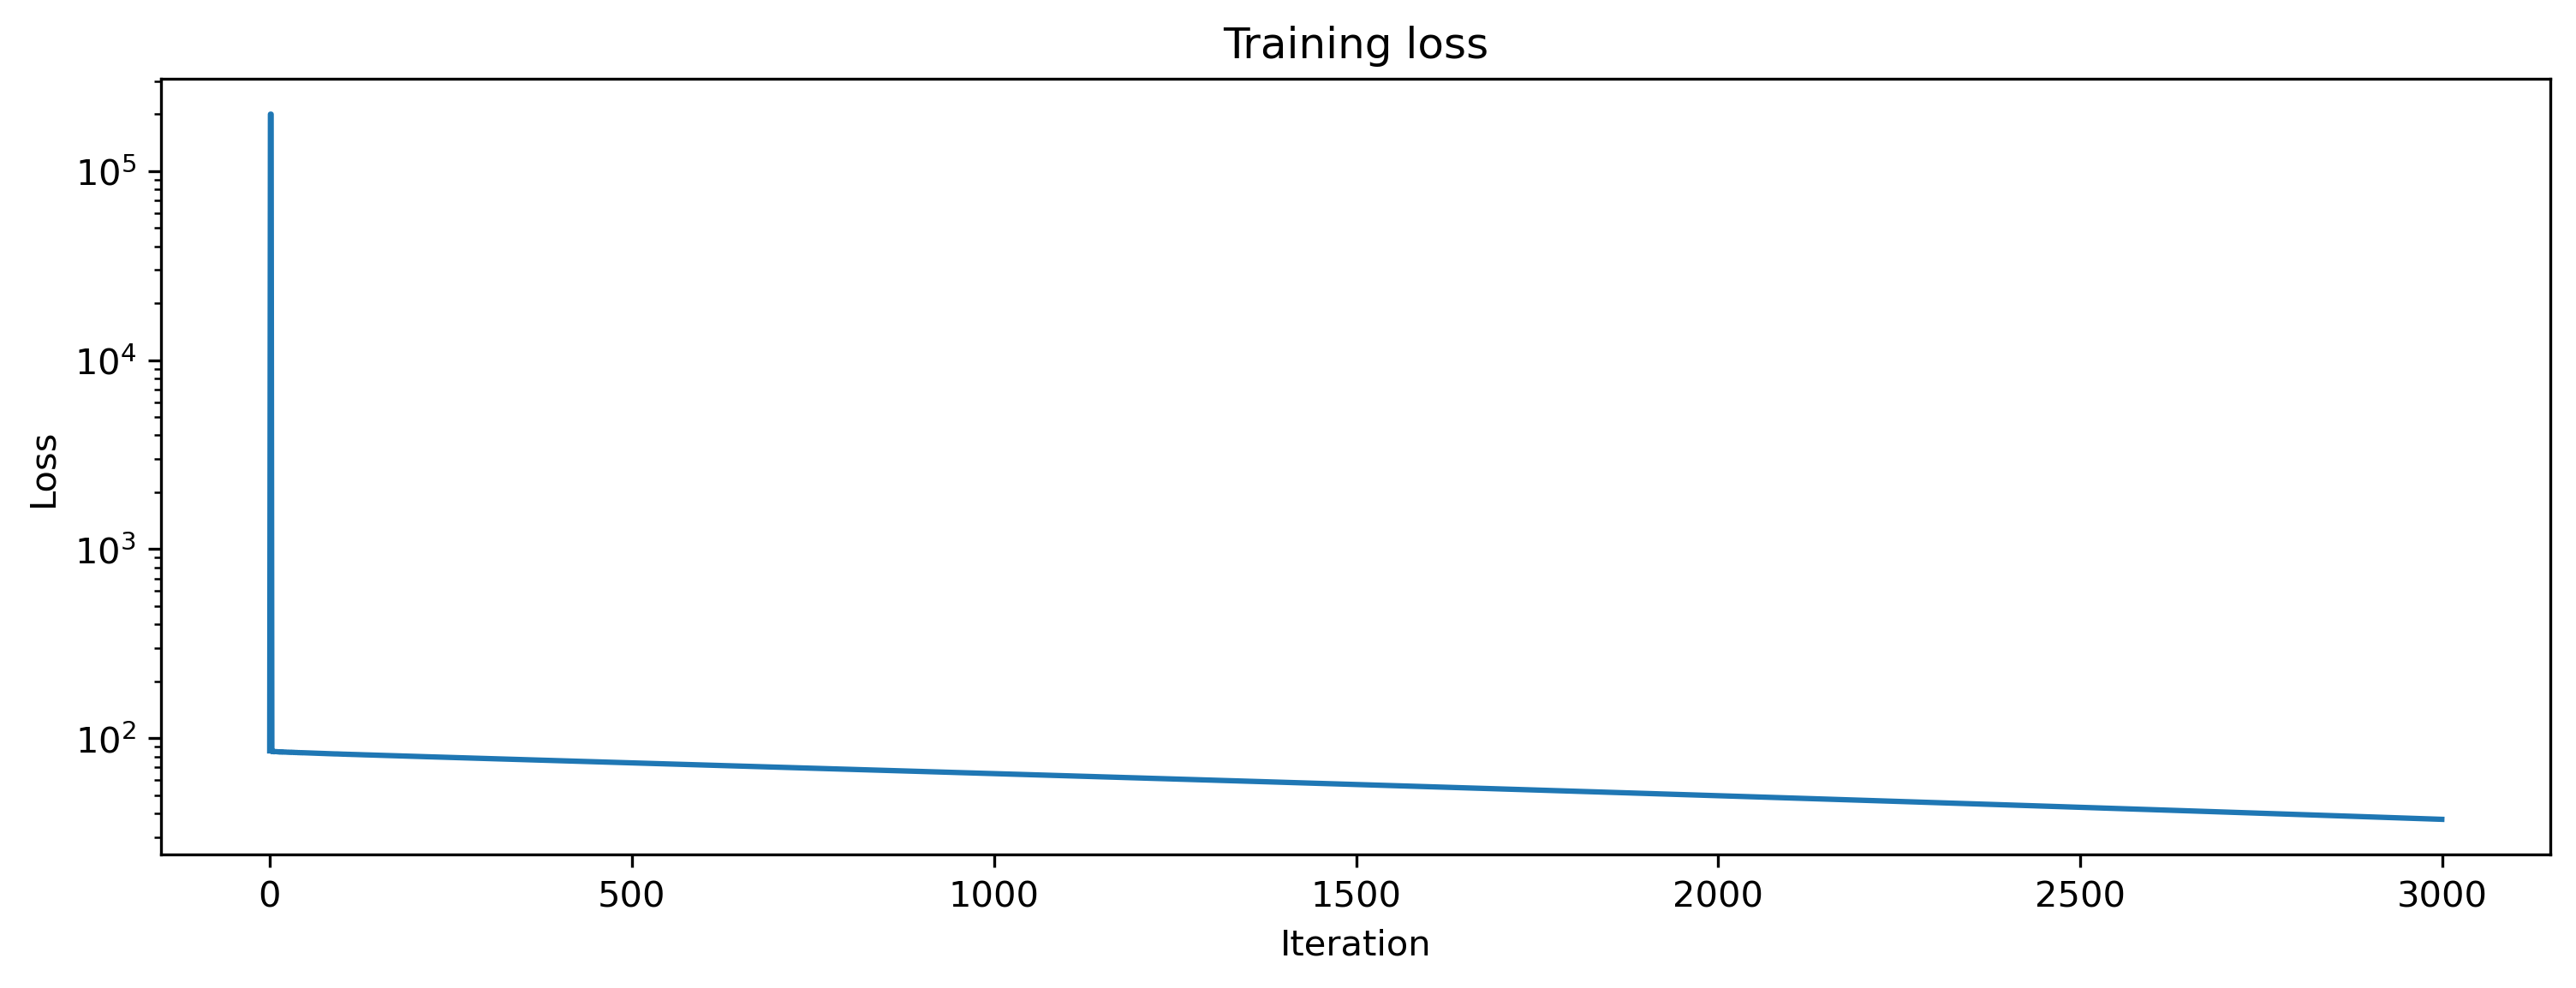

In [16]:
plt.plot(loss_t)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss');

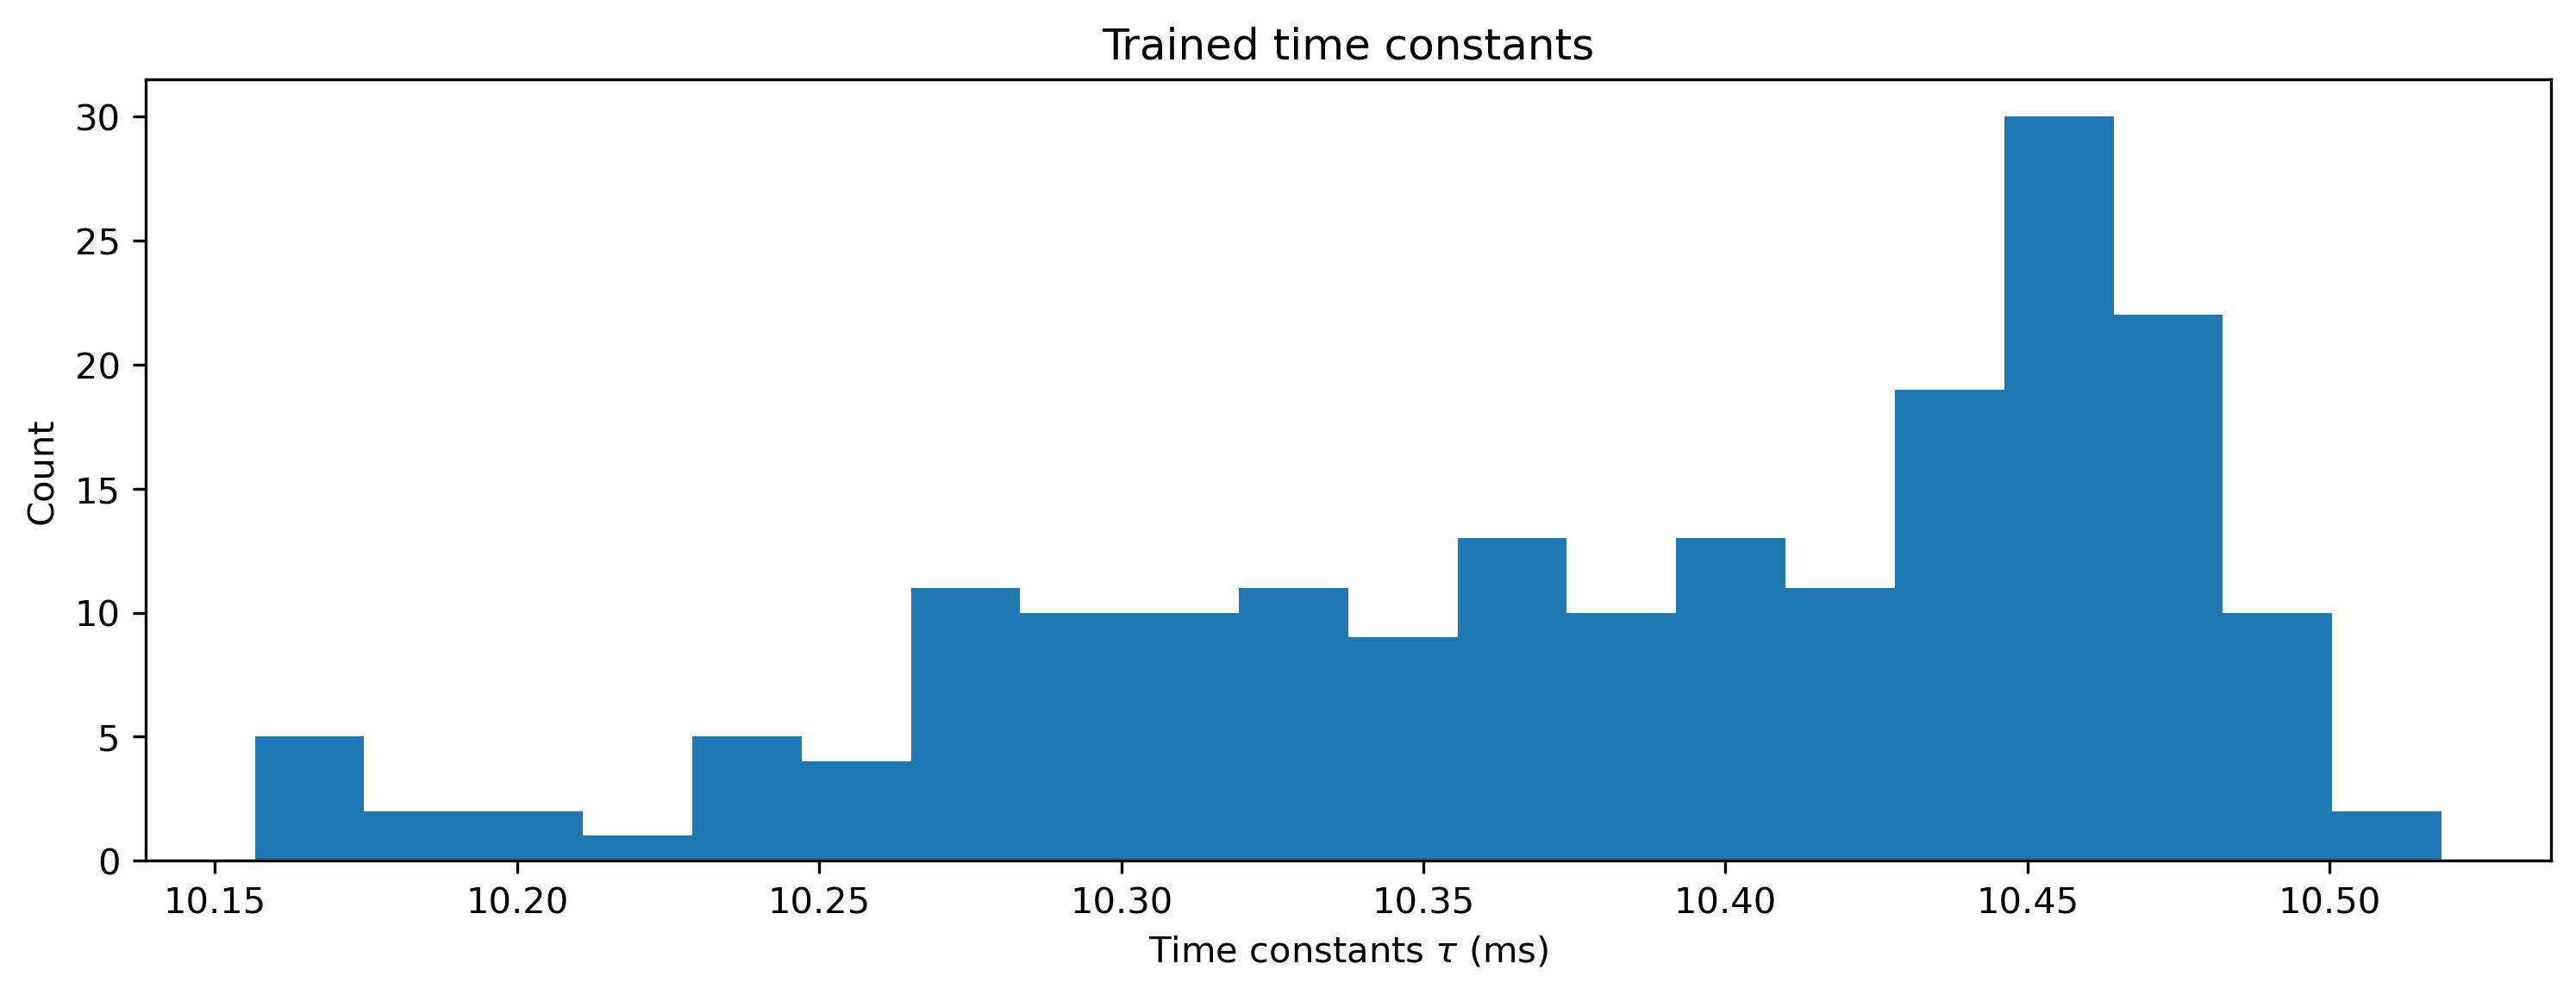

In [17]:
# - Get the final set of optimised parameters and apply them
params = get_params(opt_state)
net_stateful = net_stateful.set_attributes(params)

# - Visualise the time constants
plt.hist(net_stateful[1].tau * 1e3, 20);
plt.xlabel('Time constants $\\tau$ (ms)')
plt.ylabel('Count')
plt.title('Trained time constants');